Narrabeen-Collaroy, Australia



## Initial settings

In [1]:

import os
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.ion()
import pandas as pd
from datetime import datetime
import pytz
from coastsat import SDS_download, SDS_preprocess, SDS_shoreline, SDS_tools, SDS_transects 

## Retrieval of the images from GEE



In [2]:
# region of interest (longitude, latitude)
polygon = [[[151.2957545, -33.7012561],
            [151.297557, -33.7388075],
            [151.312234, -33.7390216],
            [151.311204, -33.701399],
            [151.2957545, -33.7012561]]]
# it's recommended to convert the polygon to the smallest rectangle (sides parallel to coordinate axes)       
polygon = SDS_tools.smallest_rectangle(polygon)
# or load from .geojson
# geojson_polygon = os.path.join(os.getcwd(), 'examples', 'NARRA_polygon.geojson')
# polygon = SDS_tools.polygon_from_geojson(geojson_polygon)
# or load from .kml
# kml_polygon = os.path.join(os.getcwd(), 'examples', 'NARRA_polygon.kml')
# polygon = SDS_tools.polygon_from_kml(kml_polygon)
# date range
dates = ['2024-01-01', '2024-10-01']
# satellite missions ['L5','L7','L8','L9','S2']
sat_list = ['L8','L9','S2']
# name of the site
sitename = 'NARRA'
# directory where the data will be stored
filepath = "B:\Project Ocean\CoastSat-master\CoastSat-master\data"
# put all the inputs into a dictionnary
inputs = {'polygon': polygon, 'dates': dates, 'sat_list': sat_list,
          'sitename': sitename, 'filepath':filepath}
# optionally, you can select your Sentinel-2 or Landsat tile to avoid duplicates from multiple tiles
# inputs['S2tile'] = '56HLH'
# inputs['LandsatWRS'] = '089083'
# before downloading the images, check how many images are available for your inputs
SDS_download.check_images_available(inputs)

GEE initialized (existing token).
Number of images available between 2024-01-01 and 2024-10-01:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
     L8: 30 images
     L9: 27 images
     S2: 94 images
  Total to download: 151 images
L8: 30/30 images already exist, 0 to be downloaded
L9: 27/27 images already exist, 0 to be downloaded
S2: 94/94 images already exist, 0 to be downloaded
- In Landsat Tier 2 (not suitable for time-series analysis):
     L8: 2 images
  Total Tier 2: 2 images


({'L8': [], 'L9': [], 'S2': []},
 {'L8': [{'type': 'Image',
    'bands': [{'id': 'B1',
      'data_type': {'type': 'PixelType', 'precision': 'float'},
      'dimensions': [7701, 7751],
      'crs': 'EPSG:32656',
      'crs_transform': [30, 0, 269385, 0, -30, -3555585]},
     {'id': 'B2',
      'data_type': {'type': 'PixelType', 'precision': 'float'},
      'dimensions': [7701, 7751],
      'crs': 'EPSG:32656',
      'crs_transform': [30, 0, 269385, 0, -30, -3555585]},
     {'id': 'B3',
      'data_type': {'type': 'PixelType', 'precision': 'float'},
      'dimensions': [7701, 7751],
      'crs': 'EPSG:32656',
      'crs_transform': [30, 0, 269385, 0, -30, -3555585]},
     {'id': 'B4',
      'data_type': {'type': 'PixelType', 'precision': 'float'},
      'dimensions': [7701, 7751],
      'crs': 'EPSG:32656',
      'crs_transform': [30, 0, 269385, 0, -30, -3555585]},
     {'id': 'B5',
      'data_type': {'type': 'PixelType', 'precision': 'float'},
      'dimensions': [7701, 7751],
      '

In [4]:
metadata = SDS_download.retrieve_images(inputs)

GEE initialized (existing token).
Number of images available between 2024-01-01 and 2024-10-01:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
     L8: 30 images
     L9: 27 images
     S2: 94 images
  Total to download: 151 images
- In Landsat Tier 2 (not suitable for time-series analysis):
     L8: 2 images
  Total Tier 2: 2 images

L8: 30 images
100%
L9: 27 images
100%
S2: 94 images
100%
Satellite images downloaded from GEE and save in C:\Users\kilia\Documents\GitHub\CoastSat\data\NARRA


In [3]:
metadata = SDS_download.get_metadata(inputs)

## Shoreline extraction


In [4]:
settings = {
    # general parameters:
    'cloud_thresh': 0.5,        
    'dist_clouds': 300,        
    'output_epsg': 28356,       
    # quality control:
    'check_detection': True,    
    'adjust_detection': False, 
    'save_figure': True,        
    # [ONLY FOR ADVANCED USERS] 
    'min_beach_area': 1000,     
    'min_length_sl': 500,       
    'cloud_mask_issue': False,  
    'sand_color': 'default',   
    'pan_off': False,          
    's2cloudless_prob': 60,     
    # add the inputs defined previously
    'inputs': inputs,
}

In [8]:
SDS_preprocess.save_jpg(metadata, settings, use_matplotlib=True)

Saving images as jpg:
L8: 30 images
100%
L9: 27 images
100%
S2: 94 images
100%
Satellite images saved as .jpg in B:\Project Ocean\CoastSat-master\CoastSat-master\data\NARRA\jpg_files\preprocessed


In [9]:
# create timelapse animation
fn_animation = os.path.join(inputs['filepath'],inputs['sitename'], '%s_animation_RGB.gif'%inputs['sitename'])
fp_images = os.path.join(inputs['filepath'], inputs['sitename'], 'jpg_files', 'preprocessed')
fps = 4 # frames per second in animation
SDS_tools.make_animation_mp4(fp_images, fps, fn_animation)

Animation has been generated (using 4 frames per second) and saved at B:\Project Ocean\CoastSat-master\CoastSat-master\data\NARRA\NARRA_animation_RGB.gif


### Digitize a reference shoreline

In [5]:
%matplotlib qt
settings['reference_shoreline'] = SDS_preprocess.get_reference_sl(metadata, settings)
settings['max_dist_ref'] = 100 # max distance (in meters) allowed from the reference shoreline

Reference shoreline already exists and was loaded
Reference shoreline coordinates are in epsg:28356


### Batch shoreline detection


In [ ]:
%matplotlib qt
output = SDS_shoreline.extract_shorelines(metadata, settings)

Mapping shorelines:
L8:   10%

In [ ]:
output = SDS_tools.remove_duplicates(output) 
output = SDS_tools.remove_inaccurate_georef(output, 10) 

14 duplicates
2 bad georef


In [14]:
from pyproj import CRS
geomtype = 'lines' # choose 'points' or 'lines' for the layer geometry
gdf = SDS_tools.output_to_gdf(output, geomtype)
if gdf is None:
    raise Exception("output does not contain any mapped shorelines")
gdf.crs = CRS(settings['output_epsg']) # set layer projection
# save GEOJSON layer to file
fp_geojson = os.path.join(inputs['filepath'], inputs['sitename'], '%s_output_%s.geojson'%(sitename,geomtype))
gdf.to_file(fp_geojson,driver='GeoJSON', encoding='utf-8')
print('Saved spatial layer at %s'%fp_geojson)

Saved spatial layer at B:\Project Ocean\CoastSat-master\CoastSat-master\data\NARRA\NARRA_output_lines.geojson


In [15]:
# create MP4 timelapse animation
fn_animation = os.path.join(inputs['filepath'],inputs['sitename'], '%s_animation_shorelines.gif'%inputs['sitename'])
fp_images = os.path.join(inputs['filepath'], inputs['sitename'], 'jpg_files', 'detection')
fps = 4 # frames per second in animation
SDS_tools.make_animation_mp4(fp_images, fps, fn_animation)

Animation has been generated (using 4 frames per second) and saved at B:\Project Ocean\CoastSat-master\CoastSat-master\data\NARRA\NARRA_animation_shorelines.gif


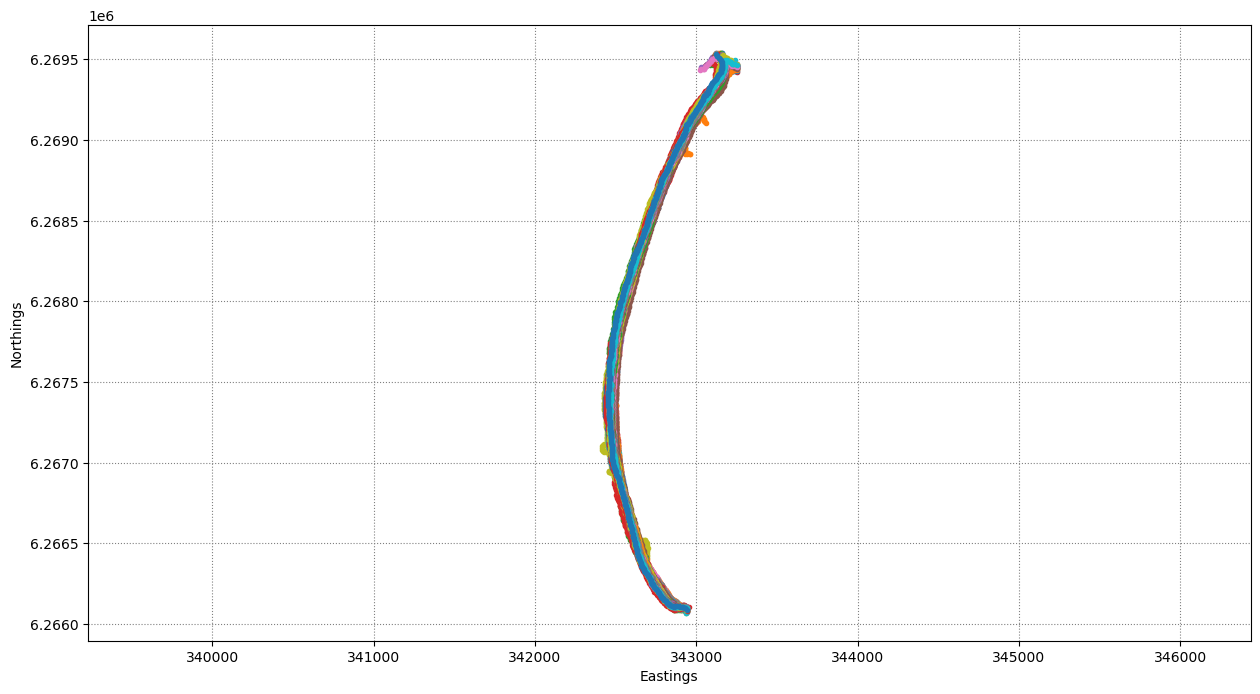

In [16]:
%matplotlib inline
fig = plt.figure(figsize=[15,8])
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')
for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    date = output['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'))
# plt.legend();

## Shoreline analysis


In [17]:
filepath = os.path.join(inputs['filepath'], sitename)
with open(os.path.join(filepath, sitename + '_output' + '.pkl'), 'rb') as f:
    output = pickle.load(f)
# remove duplicates (images taken on the same date by the same satellite)
output = SDS_tools.remove_duplicates(output)
# remove inaccurate georeferencing (set threshold to 10 m)
output = SDS_tools.remove_inaccurate_georef(output, 10)

14 duplicates
2 bad georef


In [ ]:
%matplotlib qt
transects = SDS_transects.draw_transects(output, settings)

Transect locations saved in B:\Project Ocean\CoastSat-master\CoastSat-master\data\NARRA


In [22]:
fig = plt.figure(figsize=[15,8], tight_layout=True)
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')
for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    date = output['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'))
for i,key in enumerate(list(transects.keys())):
    plt.plot(transects[key][0,0],transects[key][0,1], 'bo', ms=5)
    plt.plot(transects[key][:,0],transects[key][:,1],'k-',lw=1)
    plt.text(transects[key][0,0]-100, transects[key][0,1]+100, key,
                va='center', ha='right', bbox=dict(boxstyle="square", ec='k',fc='w'))
fig.savefig(os.path.join(filepath,'%s_mapped_shorelines.jpg'%sitename),dpi=200)

In [23]:
# along-shore distance over which to consider shoreline points to compute the median intersection
settings_transects = {'along_dist':25}
cross_distance = SDS_transects.compute_intersection(output, transects, settings_transects) 

In [ ]:
settings_transects = { # parameters for computing intersections
                      'along_dist':          25,      
                      'min_points':          3,        
                      'max_std':             15,       
                      'max_range':           30,      
                      'min_chainage':        -100,      
                      'multiple_inter':      'auto',   
                      'auto_prc':            0.1,       
                     }
cross_distance = SDS_transects.compute_intersection_QC(output, transects, settings_transects) 

Plot the time-series of shoreline change along each transect

In [25]:
fig = plt.figure(figsize=[15,8], tight_layout=True)
gs = gridspec.GridSpec(len(cross_distance),1)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.05)
for i,key in enumerate(cross_distance.keys()):
    if np.all(np.isnan(cross_distance[key])):
        continue
    idx_nan = np.isnan(cross_distance[key])
    dates = [output['dates'][_] for _ in np.where(~idx_nan)[0]]
    chainage = cross_distance[key][~idx_nan]
    ax = fig.add_subplot(gs[i,0])
    ax.grid(linestyle=':', color='0.5')
    ax.plot(dates, chainage, '-o', ms=6, mfc='w')
    ax.set_ylabel('distance [m]', fontsize=12)
    ax.text(0.5,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
            va='top', transform=ax.transAxes, fontsize=14)
fig.savefig(os.path.join(filepath,'%s_timeseries_raw.jpg'%sitename),dpi=200)

In [29]:
# save a .csv file for Excel users
out_dict = dict([])
out_dict['dates'] = output['dates']
for key in transects.keys():
    out_dict[key] = cross_distance[key]
df = pd.DataFrame(out_dict)
fn = r"B:\Project Ocean\CoastSat-master\CoastSat-master\data\time_series_raw.csv"
df.to_csv(fn, sep=',')
print('Time-series of the shoreline change along the transects saved as:\n%s'%fn)

Time-series of the shoreline change along the transects saved as:
B:\Project Ocean\CoastSat-master\CoastSat-master\data\time_series_raw.csv


## Tidal correction


Use Tidal data for correction of original time series

In [33]:
# load the measured tide data
filepath = r"B:\Project Ocean\CoastSat-master\CoastSat-master\data\NARRA_tides.csv"
tide_data = pd.read_csv(filepath)
dates_ts = [pd.to_datetime(_).to_pydatetime() for _ in tide_data['dates']]
tides_ts = np.array(tide_data['tide'])

# get tide levels corresponding to the time of image acquisition
dates_sat = output['dates']
tides_sat = SDS_tools.get_closest_datapoint(dates_sat, dates_ts, tides_ts)

# plot the subsampled tide data
fig, ax = plt.subplots(1,1,figsize=(15,4), tight_layout=True)
ax.grid(which='major', linestyle=':', color='0.5')
ax.plot(dates_ts, tides_ts, '-', color='0.6', label='all time-series')
ax.plot(dates_sat, tides_sat, '-o', color='k', ms=6, mfc='w',lw=1, label='image acquisition')
ax.set(ylabel='tide level [m]',xlim=[dates_sat[0],dates_sat[-1]], title='Tide levels at the time of image acquisition');
ax.legend()
fig.savefig(r'B:\Project Ocean\CoastSat-master\CoastSat-master\data\NARRA\tide_timeseries.jpg',dpi=200)

Extracting closest points: 100%

In [34]:
# tidal correction along each transect
reference_elevation = 0 # elevation at which you would like the shoreline time-series to be
beach_slope = 0.1
cross_distance_tidally_corrected = {}
for key in cross_distance.keys():
    correction = (tides_sat-reference_elevation)/beach_slope
    cross_distance_tidally_corrected[key] = cross_distance[key] + correction
    
# store the tidally-corrected time-series in a .csv file
out_dict = dict([])
out_dict['dates'] = dates_sat
for key in cross_distance_tidally_corrected.keys():
    out_dict[key] = cross_distance_tidally_corrected[key]
df = pd.DataFrame(out_dict)
fn = r"B:\Project Ocean\CoastSat-master\CoastSat-master\data\Tidal\transect_time_series_tidally_corrected.csv"
df.to_csv(fn, sep=',')
print('Tidally-corrected time-series of the shoreline change along the transects saved as:\n%s'%fn)

# plot the time-series of shoreline change (both raw and tidally-corrected)
fig = plt.figure(figsize=[15,8], tight_layout=True)
gs = gridspec.GridSpec(len(cross_distance),1)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.05)
for i,key in enumerate(cross_distance.keys()):
    if np.all(np.isnan(cross_distance[key])):
        continue
    idx_nan = np.isnan(cross_distance[key])
    dates = [output['dates'][_] for _ in np.where(~idx_nan)[0]]
    chainage = cross_distance[key][~idx_nan]
    chainage_corrected = cross_distance_tidally_corrected[key][~idx_nan]
    ax = fig.add_subplot(gs[i,0])
    ax.grid(linestyle=':', color='0.5')
    ax.plot(dates, chainage, '-o', ms=6, mfc='w', label='raw')
    ax.plot(dates, chainage_corrected, '-o', ms=6, mfc='w', label='tidally-corrected')
    ax.set_ylabel('distance [m]', fontsize=12)
    ax.text(0.5,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
            va='top', transform=ax.transAxes, fontsize=14)
ax.legend()
fig.savefig(r'B:\Project Ocean\CoastSat-master\CoastSat-master\data\Tidal\timeseries_corrected.jpg',dpi=200)

Tidally-corrected time-series of the shoreline change along the transects saved as:
B:\Project Ocean\CoastSat-master\CoastSat-master\data\Tidal\transect_time_series_tidally_corrected.csv


In [37]:
import numpy as np
import pandas as pd

# --- Compute RMSE for each transect ---

rmse_dict = {}

for key in cross_distance.keys():
    raw = cross_distance[key]
    corrected = cross_distance_tidally_corrected[key]
    
    # Identify indices where both raw and corrected data are valid (non-NaN)
    valid_idx = ~np.isnan(raw) & ~np.isnan(corrected)
    
    # Compute RMSE only if valid data exists; else, mark as NaN
    if np.sum(valid_idx) == 0:
        rmse = np.nan
    else:
        differences = raw[valid_idx] - corrected[valid_idx]
        rmse = np.sqrt(np.mean(differences ** 2))
    
    rmse_dict[key] = rmse
    print(f"Transect '{key}' - RMSE: {rmse:.3f} m")

# Optionally, save the RMSE values into a CSV file
rmse_df = pd.DataFrame(list(rmse_dict.items()), columns=['Transect', 'RMSE_m'])
rmse_csv_path = r"B:\Project Ocean\CoastSat-master\CoastSat-master\data\Tidal\rmse_tidally_corrected.csv"
rmse_df.to_csv(rmse_csv_path, index=False)
print(f"RMSE values saved as CSV:\n{rmse_csv_path}")

# --- Find Min and Max distances for each transect for both raw and corrected data ---

# Dictionaries to store min and max values
min_raw = {}
max_raw = {}
min_corrected = {}
max_corrected = {}

for key in cross_distance.keys():
    raw_data = cross_distance[key]
    corrected_data = cross_distance_tidally_corrected[key]
    
    # np.nanmin and np.nanmax ignore NaN values.
    # If an entire array is NaN these functions will raise an error. 
    # We can handle that by checking if all values are NaN.
    if np.all(np.isnan(raw_data)):
        min_raw[key] = np.nan
        max_raw[key] = np.nan
    else:
        min_raw[key] = np.nanmin(raw_data)
        max_raw[key] = np.nanmax(raw_data)
    
    if np.all(np.isnan(corrected_data)):
        min_corrected[key] = np.nan
        max_corrected[key] = np.nan
    else:
        min_corrected[key] = np.nanmin(corrected_data)
        max_corrected[key] = np.nanmax(corrected_data)
    
    print(f"Transect '{key}':")
    print(f"    Raw data:      min = {min_raw[key]:.3f} m, max = {max_raw[key]:.3f} m")
    print(f"    Corrected data: min = {min_corrected[key]:.3f} m, max = {max_corrected[key]:.3f} m")

# Optionally, create a DataFrame combining these statistics for further analysis or saving as CSV
stats_df = pd.DataFrame({
    'Transect': list(cross_distance.keys()),
    'Raw_Min': [min_raw[k] for k in cross_distance.keys()],
    'Raw_Max': [max_raw[k] for k in cross_distance.keys()],
    'Corrected_Min': [min_corrected[k] for k in cross_distance.keys()],
    'Corrected_Max': [max_corrected[k] for k in cross_distance.keys()],
    'RMSE': [rmse_dict[k] for k in cross_distance.keys()]
})
stats_csv_path = r"B:\Project Ocean\CoastSat-master\CoastSat-master\data\Tidal\transect_stats.csv"
stats_df.to_csv(stats_csv_path, index=False)
print(f"Transect statistics (min, max, RMSE) saved as CSV:\n{stats_csv_path}")


Transect '1' - RMSE: 3.381 m
Transect '2' - RMSE: 3.434 m
Transect '3' - RMSE: 3.420 m
Transect '4' - RMSE: 3.420 m
Transect '5' - RMSE: 3.465 m
Transect '6' - RMSE: 3.462 m
Transect '7' - RMSE: 3.500 m
Transect '8' - RMSE: 3.447 m
RMSE values saved as CSV:
B:\Project Ocean\CoastSat-master\CoastSat-master\data\Tidal\rmse_tidally_corrected.csv
Transect '1':
    Raw data:      min = 188.156 m, max = 255.338 m
    Corrected data: min = 185.086 m, max = 257.095 m
Transect '2':
    Raw data:      min = 192.937 m, max = 254.550 m
    Corrected data: min = 198.442 m, max = 250.813 m
Transect '3':
    Raw data:      min = 228.475 m, max = 282.178 m
    Corrected data: min = 225.405 m, max = 278.441 m
Transect '4':
    Raw data:      min = 357.938 m, max = 423.501 m
    Corrected data: min = 363.347 m, max = 419.764 m
Transect '5':
    Raw data:      min = 202.970 m, max = 264.544 m
    Corrected data: min = 208.754 m, max = 261.489 m
Transect '6':
    Raw data:      min = 187.498 m, max = 249.

## Validation against surveys

Now compare the surveys to the satellite-derived shorelines from 2024 loaded previously.

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# File input/output settings
# -------------------------------
regen_csv = r"B:\Project Ocean\CoastSat-master\CoastSat-master\data\Originaldata.csv"
output_folder = os.path.join(os.getcwd(), 'original_data_plots')
os.makedirs(output_folder, exist_ok=True)

# -------------------------------
# Load the CSV file
# -------------------------------
df_regen = pd.read_csv(regen_csv, parse_dates=['dates'])

# Remove extra index column if present
if "Unnamed: 0" in df_regen.columns:
    df_regen.drop(columns=["Unnamed: 0"], inplace=True)

print("Loaded regenerated time-series data.")

# -------------------------------
# Get transect keys
# -------------------------------
transect_keys = [col for col in df_regen.columns if col != 'dates']
transect_keys = sorted(transect_keys, key=lambda x: int(x))
n_transects = len(transect_keys)

# -------------------------------
# Set up subplots
# -------------------------------
cols = 3  # Number of columns in subplot grid
rows = (n_transects + cols - 1) // cols  # Equivalent to ceil(n / cols) without importing math
fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows), sharex=True)
axes = axes.flatten()

# -------------------------------
# Plot each transect in a subplot
# -------------------------------
for i, key in enumerate(transect_keys):
    df_plot = df_regen[['dates', key]].dropna().sort_values('dates')
    ax = axes[i]
    ax.plot(df_plot['dates'], df_plot[key], '-', label=f'Transect {key}', linewidth=1.2)
    ax.set_title(f"Transect {key}")
    ax.set_ylabel("Shoreline Position [m]")
    ax.grid(True, linestyle=':', color='0.5')
    ax.legend(fontsize='small')

# Hide any unused subplots (if total plots < rows * cols)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# -------------------------------
# Final layout and save
# -------------------------------
fig.suptitle("Original Data Time Series - All Transects", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the main title
plot_filename = os.path.join(output_folder, "original_all_transects_subplots.jpg")
fig.savefig(plot_filename, dpi=150)
plt.close()

print(f"Combined subplot image saved as {plot_filename}")


Loaded regenerated time-series data.
Combined subplot image saved as b:\Project Ocean\CoastSat-master\CoastSat-master\original_data_plots\original_all_transects_subplots.jpg


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import timedelta
from scipy import interpolate, stats

# -------------------------------
# File input/output settings
# -------------------------------
raw_csv = r"B:\Project Ocean\CoastSat-master\CoastSat-master\data\time_series_raw.csv"
regen_csv = r"B:\Project Ocean\CoastSat-master\CoastSat-master\data\Originaldata.csv"
output_folder = os.path.join(os.getcwd(), 'comparison_plots')
os.makedirs(output_folder, exist_ok=True)

# -------------------------------
# Load the CSV files
# -------------------------------
df_raw = pd.read_csv(raw_csv, parse_dates=['dates'])
df_regen = pd.read_csv(regen_csv, parse_dates=['dates'])

# Remove extra index column if present
if "Unnamed: 0" in df_raw.columns:
    df_raw.drop(columns=["Unnamed: 0"], inplace=True)
if "Unnamed: 0" in df_regen.columns:
    df_regen.drop(columns=["Unnamed: 0"], inplace=True)

print("Loaded raw and regenerated time-series data.")

# -------------------------------
# Set parameters for comparison
# -------------------------------
sett = {
    'min_days': 3,    # If the nearest neighbor is less than 3 days away, use that point directly.
    'max_days': 10,   # Maximum time difference in days to allow for a comparison.
    'binwidth': 3,    # Binwidth for the error histogram.
    'lims': [-50, 50] # Limits for error plotting.
}

# -------------------------------
# Loop through each transect and generate plots
# -------------------------------
# Get transect keys (we assume all columns except "dates" are transect columns)
transect_keys = [col for col in df_raw.columns if col != 'dates']
# Order keys numerically if they are named "1", "2", etc.
transect_keys = sorted(transect_keys, key=lambda x: int(x))

for key in transect_keys:
    # --- Merge the two datasets by date using nearest neighbour interpolation ---
    # Both CSV files are assumed to have a "dates" column.
    # Using merge_asof to get nearest date within 'max_days' tolerance.
    df_raw_sorted = df_raw[['dates', key]].dropna().sort_values('dates')
    df_regen_sorted = df_regen[['dates', key]].dropna().sort_values('dates')
    
    # Rename columns to distinguish raw and regenerated values
    df_raw_sorted = df_raw_sorted.rename(columns={key: 'raw'})
    df_regen_sorted = df_regen_sorted.rename(columns={key: 'regen'})
    
    # Use merge_asof with a tolerance (convert max_days to a Timedelta)
    merged = pd.merge_asof(df_raw_sorted, df_regen_sorted, on='dates',
                           direction='nearest', tolerance=pd.Timedelta(days=sett['max_days']))
    # Drop rows where the regenerated value is missing after the merge.
    merged = merged.dropna(subset=['raw', 'regen'])
    
    if merged.empty:
        print(f"No matching data for transect {key}. Skipping plot.")
        continue

    dates_common = merged['dates']
    chain_raw = merged['raw'].values
    chain_regen = merged['regen'].values

    # --- Plotting ---
    fig = plt.figure(figsize=[15, 8], tight_layout=True)
    gs = gridspec.GridSpec(2, 3)
    
    # (a) Time-series plot
    ax0 = fig.add_subplot(gs[0, :])
    ax0.grid(linestyle=':', color='0.5')
    ax0.plot(dates_common, chain_raw, '-', mfc='w', ms=5, label='Raw')
    ax0.plot(dates_common, chain_regen, '-', mfc='w', ms=5, label='Original measured')
    ax0.set_title(f"Transect {key}")
    ax0.legend()
    
    # Compute error statistics using raw as "truth" and regenerated as "measurement"
    slope, intercept, r_value, p_value, std_err = stats.linregress(chain_raw, chain_regen)
    R2 = r_value**2 
    ax0.text(0.02, 0.95, f"R² = {R2:.2f}", transform=ax0.transAxes, bbox=dict(boxstyle='square', facecolor='w', alpha=1))
    
    chain_error = chain_regen - chain_raw
    rmse = np.sqrt(np.mean(chain_error ** 2))
    mean_error = np.mean(chain_error)
    std_error = np.std(chain_error)
    q90 = np.percentile(np.abs(chain_error), 90)

    # (b) 1:1 Plot
    ax1 = fig.add_subplot(gs[1, 0])
    ax1.axis('equal')
    ax1.grid(linestyle=':', color='0.5')
    ax1.plot(chain_raw, chain_regen, 'o', ms=4, mfc='C0', mec='C0', alpha=0.7)
    # Plot 1:1 line
    min_val = min(np.min(chain_raw), np.min(chain_regen))
    max_val = max(np.max(chain_raw), np.max(chain_regen))
    ax1.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
    ax1.set_xlabel('Raw [m]')
    ax1.set_ylabel('Regenerated [m]')
    
    # (c) Boxplot of errors
    ax2 = fig.add_subplot(gs[1, 1])
    ax2.yaxis.grid(True)
    bp = ax2.boxplot(chain_error, patch_artist=True, labels=[f"Transect {key}"])
    for median in bp['medians']:
        median.set(color='k', linewidth=1.5)
    ax2.set_ylabel('Error [m]')
    ax2.set_ylim(sett['lims'])
    
    # (d) Histogram of errors
    ax3 = fig.add_subplot(gs[1, 2])
    ax3.grid(linestyle=':', color='0.5')
    ax3.axvline(x=0, ls='--', lw=1.5, color='k')
    binwidth = sett['binwidth']
    bins = np.arange(np.min(chain_error), np.max(chain_error) + binwidth, binwidth)
    ax3.hist(chain_error, bins=bins, density=True, color='0.6', edgecolor='k', alpha=0.5)
    mu, sigma = stats.norm.fit(chain_error)
    xlims = ax3.get_xlim()
    x_vals = np.linspace(xlims[0], xlims[1], 100)
    p = stats.norm.pdf(x_vals, mu, sigma)
    ax3.plot(x_vals, p, 'r-', linewidth=1)
    ax3.set_xlabel('Error [m]')
    ax3.set_ylabel('PDF')
    ax3.set_xlim(sett['lims'])
    ax3.text(0.02, 0.98, f"rmse = {rmse:.1f}\nmean = {mean_error:.1f}\nstd = {std_error:.1f}\nq90 = {q90:.1f}",
             transform=ax3.transAxes, va='top')
    
    # Save the figure
    plot_filename = os.path.join(output_folder, f"comparison_transect_{key}.jpg")
    fig.savefig(plot_filename, dpi=150)
    plt.close(fig)
    
    print(f"Transect {key}: Plot saved as {plot_filename}")

print("All comparison plots have been generated.")


Loaded raw and regenerated time-series data.
Transect 1: Plot saved as b:\Project Ocean\CoastSat-master\CoastSat-master\comparison_plots\comparison_transect_1.jpg
Transect 2: Plot saved as b:\Project Ocean\CoastSat-master\CoastSat-master\comparison_plots\comparison_transect_2.jpg
Transect 3: Plot saved as b:\Project Ocean\CoastSat-master\CoastSat-master\comparison_plots\comparison_transect_3.jpg
Transect 4: Plot saved as b:\Project Ocean\CoastSat-master\CoastSat-master\comparison_plots\comparison_transect_4.jpg
Transect 5: Plot saved as b:\Project Ocean\CoastSat-master\CoastSat-master\comparison_plots\comparison_transect_5.jpg
Transect 6: Plot saved as b:\Project Ocean\CoastSat-master\CoastSat-master\comparison_plots\comparison_transect_6.jpg
Transect 7: Plot saved as b:\Project Ocean\CoastSat-master\CoastSat-master\comparison_plots\comparison_transect_7.jpg
Transect 8: Plot saved as b:\Project Ocean\CoastSat-master\CoastSat-master\comparison_plots\comparison_transect_8.jpg
All compari